# Step-By-Step Guide to Creating a Multi-Step Agent: Integrating Medical Guidelines for Patient Decision Aid

## Introduction
This notebook demonstrates how to build an intelligent decision aid tool using Azure AI Search, Azure OpenAI, and LlamaIndex. Specifically, we will integrate and process cardiology guidelines from the [American College of Cardiology](https://www.acc.org/guidelines) to assist doctors in making patient-specific recommendations. In collaboration with a real-world cardiology professional, we showcase how artificial intelligence can assist in providing evidence-based care for complex medical cases.

By following this notebook, you will learn how to seamlessly integrate large medical datasets, apply vector search techniques, and use CrewAI agents to generate personalized decision aids for complex patient profiles.

## Prerequisites
- 🐍 Python 3.9 or higher
- ☁️ Azure OpenAI Service
- ☁️ Azure AI Search Service
- 🛠️ LlamaIndex for document parsing and querying
- 🛠️ LlamaParse for PDF extraction
- 🛠️ ReportLab for PDF generation
- 🛠️ CrewAI for multi-agent task coordination

## Features Covered
This demo covers the following features:
- ✅ **Azure AI Search** for scalable vector search and retrieval
- ✅ **Binary Quantization** for optimized vector storage
- ✅ **Azure OpenAI** for large language model integration
- ✅ **LlamaIndex** for structured document parsing and querying
- ✅ **LlamaParse** for extracting information from ACC PDFs
- ✅ **CrewAI** for multi-agent task processing
- ✅ **ReportLab** for generating detailed PDF reports


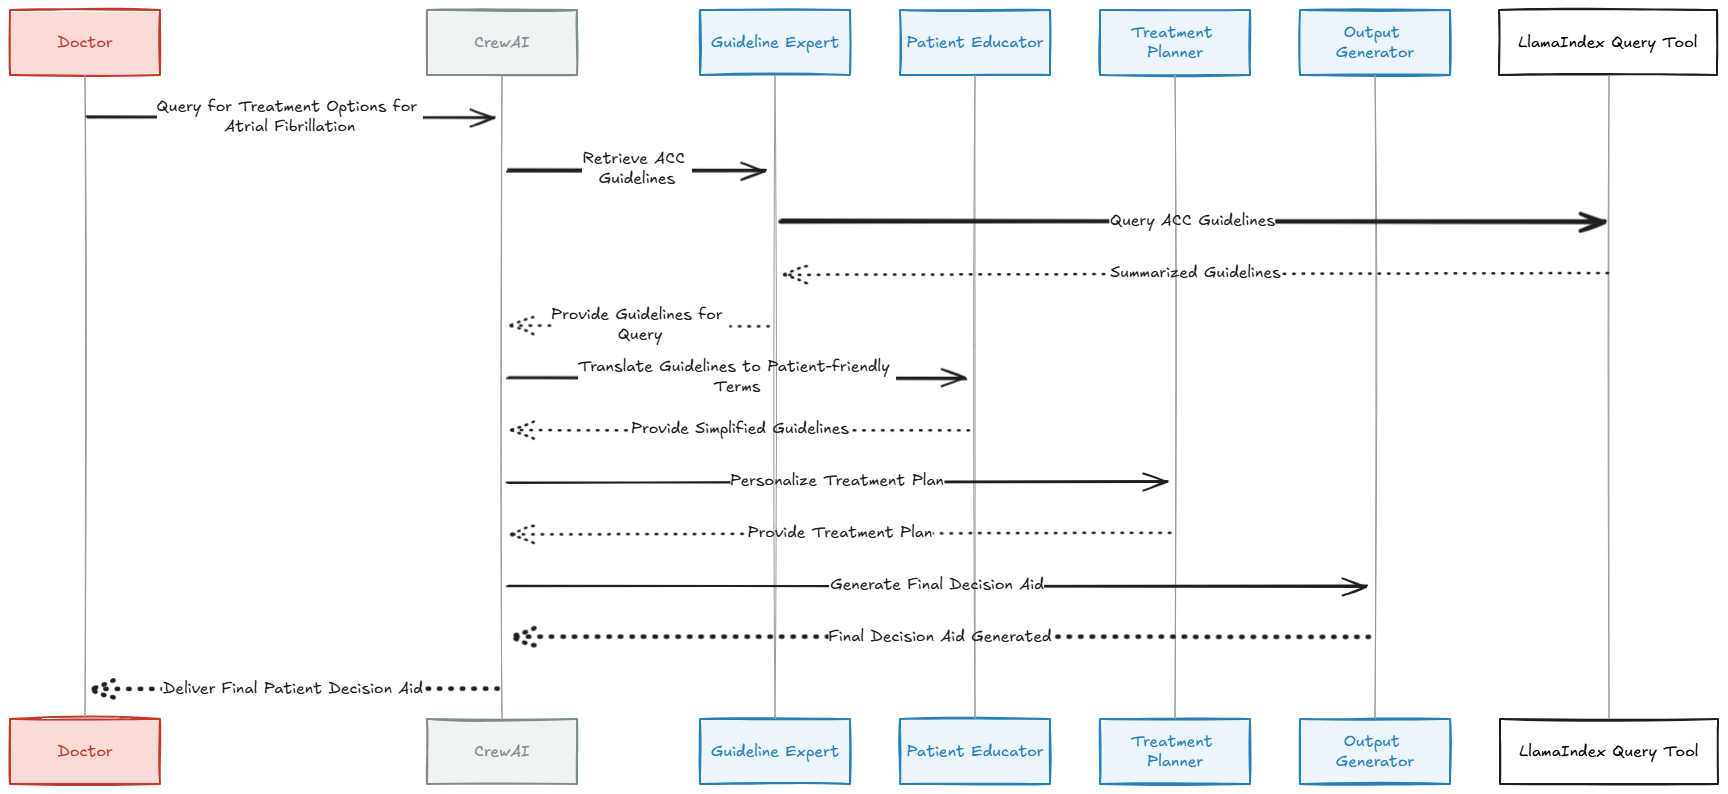

## Dataset
The dataset used in this demo includes ACC guidelines retrieved from the official [American College of Cardiology](https://www.acc.org/guidelines) website. These guidelines, focusing on managing atrial fibrillation and peripheral arterial disease, are parsed and integrated into the workflow. This notebook simulates the use case of generating a decision aid for a real cardiology patient under the supervision of a certified medical doctor.

The American College of Cardiology (ACC) is the professional home for the entire cardiovascular care team. ACC's mission is to transform cardiovascular care and improve heart health. The guidelines and information used in this demo are provided by ACC and are subject to their Terms of Service. By using this dataset, you agree to comply with and be bound by the ACC's Terms of Service.

Please note that the use of the ACC's guidelines and information in this demo is for informational purposes only and is not intended as medical advice or as a substitute for the medical advice of a physician. The information contained in this demo may or may not reflect the most current medical developments, and ACC makes no representation with respect to the quality, non-infringement, accuracy, completeness, timeliness, or reliability of such information.

Let's dive into the code and walk through how we can turn raw ACC medical guidelines into actionable insights and reports for a complex patient profile.

# Install the necessary packages:

In [ ]:
# Core dependencies
! pip install llama-index
! pip install llama-index-core

# Azure-specific dependencies
! pip install azure-search-documents==11.5.1
! pip install llama-index-vector-stores-azureaisearch
! pip install llama-index-embeddings-azure-openai
! pip install llama-index-llms-azure-openai

# Additional tools and utilities
! pip install "crewai[tools]"
! pip install llama-parse
! pip install llama-index-readers-file
! pip install matplotlib
! pip install python-dotenv
! pip install fpdf
! pip install reportlab

## Initialize Azure Services

Set up Azure OpenAI and Azure AI Search services. This includes configuring the language models and embedding models, as well as initializing the Azure Search client.


In [20]:
import os
from dotenv import load_dotenv
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from llama_index.core import SimpleDirectoryReader, StorageContext, VectorStoreIndex
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.vector_stores.azureaisearch import AzureAISearchVectorStore, IndexManagement
from llama_parse import LlamaParse
import nest_asyncio
nest_asyncio.apply()

load_dotenv()

# Environment Variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME") # I'm using GPT-4o-mini
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME") # I'm using text-embedding-3-small
SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
SEARCH_SERVICE_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
INDEX_NAME = "acc-guidelines-index"
LLAMA_CLOUD_API_KEY=os.getenv("LLAMA_CLOUD_API_KEY")

# Initialize Azure OpenAI and embedding models
llm = AzureOpenAI(
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-06-01"
)

embed_model = AzureOpenAIEmbedding(
    model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-06-01"
)

# Initialize search clients
credential = AzureKeyCredential(SEARCH_SERVICE_API_KEY)
index_client = SearchIndexClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential)
search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=credential)


## Parse ACC Guidelines PDFs

We'll parse the ACC guidelines using LlamaIndex Parser and prepare the documents for embedding and querying.


In [ ]:
from llama_parse import LlamaParse

# Set up the parser
parser = LlamaParse(
    result_type="markdown"  # Options are "markdown" or "text"
)

# Use SimpleDirectoryReader to parse all PDFs in the directory
file_extractor = {".pdf": parser}
documents = SimpleDirectoryReader(
    input_dir='data/acc', 
    file_extractor=file_extractor, 
    recursive=True
).load_data()

print(f"Number of documents parsed: {len(documents)}")


Note: The SimpleDirectoryReader will recursively read all PDFs in the data/acc directory and parse them using the LlamaIndex parser.

## Prepare and Index Documents in Azure AI Search

We'll split the parsed documents into manageable chunks and index them using Azure AI Search.


In [ ]:
from llama_index.core.extractors import TitleExtractor, QuestionsAnsweredExtractor
from llama_index.core.node_parser import TokenTextSplitter

from llama_index.core.settings import Settings

Settings.llm = llm
Settings.embed_model = embed_model

# Define whether to use an existing index or create a new one
use_existing_index = True  # Change to True if you already have an index

# Initialize the vector store based on whether we're using an existing index or creating a new one
if use_existing_index:
    vector_store = AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_client=index_client,
        index_name=INDEX_NAME,
        index_management=IndexManagement.VALIDATE_INDEX,
        id_field_key="id",
        chunk_field_key="chunk",
        embedding_field_key="embedding",
        embedding_dimensionality=1536,
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        language_analyzer="en.lucene",
        vector_algorithm_type="hnsw",
        compression_type="binary"
    )
else:
    vector_store = AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_client=index_client,
        index_name=INDEX_NAME,
        index_management=IndexManagement.CREATE_IF_NOT_EXISTS,
        id_field_key="id",
        chunk_field_key="chunk",
        embedding_field_key="embedding",
        embedding_dimensionality=1536,
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        language_analyzer="en.lucene",
        vector_algorithm_type="hnsw",
        compression_type="binary"
    )

# Load documents and create index based on the use_existing_index flag
if use_existing_index:
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    index = VectorStoreIndex.from_documents(
        [],
        storage_context=storage_context,
    )
else:
    # Configure TokenTextSplitter to split documents into manageable chunks
    text_splitter = TokenTextSplitter(
        separator=" ",  # The separator for splitting text (space in this case)
        chunk_size=1024,  # Maximum number of tokens per chunk
        chunk_overlap=102  # Overlap between chunks (I'll use 10%)
    )

    # Initialize the storage context
    storage_context = StorageContext.from_defaults(vector_store=vector_store)

    # Create the index with document splitting using the TokenTextSplitter
    index = VectorStoreIndex.from_documents(
        documents,  # This is the list of parsed documents from LlamaParse
        transformations=[text_splitter],  # Automatically splits the text for chunking
        storage_context=storage_context,
        show_progress=True
    )

## Complex Patient Profile: Sarah Johnson

The patient profile for Sarah Johnson simulates a real-world medical scenario. Sarah is a 68-year-old female with a history of multiple chronic conditions, including atrial fibrillation (AF) and peripheral arterial disease (PAD). These conditions represent a common intersection of cardiovascular diseases, often requiring complex management strategies.

### Key Aspects of the Profile:

1. **Chronic Conditions**: 
   Sarah's chronic conditions such as atrial fibrillation, hypertension, and hyperlipidemia make her a high-risk patient for cardiovascular events, particularly stroke. Her management involves balancing rhythm and rate control strategies, as well as anticoagulation therapy to reduce stroke risk. Her **CHA2DS2-VASc score** (which assesses stroke risk in AF patients) is 4, placing her in a category where anticoagulation is recommended.

2. **Medication Management**: 
   Sarah’s current medications, including **Flecainide** (for rhythm control) and **Apixaban** (for anticoagulation), are reflective of standard care practices for managing atrial fibrillation. The inclusion of drugs like **Metoprolol** and **Atorvastatin** addresses co-morbidities such as hypertension and high cholesterol, which often accompany AF.

3. **Lifestyle Factors**:
   Sarah’s smoking history, though she quit 5 years ago, remains a significant risk factor for PAD and cardiovascular disease. Her active lifestyle (4-5 days of physical activity per week) and adherence to a heart-healthy, low-sodium diet indicate positive lifestyle interventions, which are critical components in managing her conditions.

4. **Lab Results and Vital Signs**:
   Sarah’s recent lab results (e.g., INR, creatinine, cholesterol levels) are crucial in monitoring both her cardiovascular risk and the effectiveness of her medications. For example, her **INR** of 1.4 suggests her anticoagulation therapy is well-managed, reducing her risk of stroke while balancing the risk of bleeding.

5. **Mental Health and Preferences**:
   The profile includes a brief mental health assessment indicating that Sarah experiences anxiety but not depression, which is important in understanding her emotional response to her chronic conditions and treatments. Her treatment preferences for minimally invasive procedures and non-opioid pain management reflect patient-centered care approaches, aligning with her values and goals for treatment.

6. **Recent Visits and Surgical History**:
   Sarah’s recent visits for atrial fibrillation and PAD management illustrate ongoing management of her conditions. The mention of considering **catheter ablation** reflects a common decision point for AF patients who experience recurrence despite pharmacological treatment.

7. **Risk Scores**:
   Tools such as the **CHA2DS2-VASc score** and **HAS-BLED score** are used in clinical practice to assess stroke risk and bleeding risk in AF patients, respectively. Sarah’s scores are 4 (moderate-to-high stroke risk) and 2 (moderate bleeding risk), which helps guide therapeutic decisions, such as whether to continue anticoagulation therapy.

### Simulating a Real-World Scenario:
This profile simulates the comprehensive details a healthcare provider would need to consider in managing a complex patient with cardiovascular disease. From medication management to understanding patient preferences and assessing risk through validated tools, Sarah's profile is representative of real patient cases in cardiology. Healthcare providers can use this information to make informed, evidence-based decisions, such as whether to recommend catheter ablation or adjust anticoagulation therapy based on her risk scores.

### Disclaimer:
**This patient profile is fictional and is used for demonstration purposes only.** The data does not represent any real individual, and the use case is designed to illustrate how AI tools like Azure AI Search, LlamaIndex, and CrewAI can assist in medical decision-making by automating the retrieval of relevant medical guidelines and generating patient-specific recommendations.


In [8]:
# Define complex patient profile
patient_profile = {
    "patient_id": "43454357890",
    "name": "Sarah Johnson",
    "age": 68,
    "gender": "Female",
    "height_cm": 165,
    "weight_kg": 72,
    "bmi": 26.4,
    "blood_type": "A-",
    "allergies": ["Sulfa drugs"],
    "current_medications": [
        "Flecainide",
        "Apixaban",
        "Metoprolol",
        "Atorvastatin",
        "Cilostazol",
    ],
    "chronic_conditions": {
        "atrial_fibrillation": True,
        "peripheral_arterial_disease": True,
        "hypertension": True,
        "hyperlipidemia": True,
        "coronary_artery_disease": False,
    },
    "family_medical_history": {"heart_disease": True, "stroke": True, "cancer": False},
    "lifestyle_factors": {
        "smoking": "Former smoker, quit 5 years ago",
        "alcohol_use": "Rare",
        "physical_activity_per_week": "4-5 days",
        "diet": "Heart-healthy, low-sodium",
        "sleep_hours_per_night": 6,
    },
    "recent_lab_results": {
        "inr": 1.4, 
        "creatinine_mg_dl": 1.1,
        "ldl_cholesterol_mg_dl": 85,
        "hdl_cholesterol_mg_dl": 55,
        "blood_pressure_mm_hg": "135/80",
    },
    "vaccination_status": {
        "influenza_vaccine": True,
        "covid_vaccine": True,
        "pneumonia_vaccine": True,
    },
    "surgical_history": [
        "Carotid endarterectomy",  
        "Cholecystectomy",         
    ],
    "imaging_history": {
        "last_echocardiogram_date": "2024-07-15",
        "last_carotid_ultrasound_date": "2024-06-20",
    },
    "mental_health": {
        "anxiety": True,
        "depression": False,
        "cognitive_function_issues": False,
    },
    "preferences": {
        "preferred_treatment_type": [
            "Minimally invasive procedures",
            "Evidence-based treatments",
        ],
        "end_of_life_care": "Yes",
        "pain_management": "Non-opioid",
    },
    "recent_visits": [
        {
            "visit_date": "2024-08-25",
            "reason": "Follow-up for atrial fibrillation",
            "notes": "Recurrence of AF despite flecainide. Discussing ablation vs alternative antiarrhythmic options.",
        },
        {
            "visit_date": "2024-07-10",
            "reason": "Peripheral arterial disease management",
            "notes": "Stable claudication symptoms. Continue current management and exercise program.",
        },
    ],
    "af_management": {
        "current_treatment": "Flecainide",
        "treatment_history": [
            "Rate control with metoprolol",
            "Rhythm control with flecainide",
        ],
        "af_recurrence": True,
        "considering_options": ["Catheter ablation", "Alternative antiarrhythmic drug"],
        "chads2_vasc_score": 4,
        "has_bled_score": 2,
    },
    "pad_management": {
        "ankle_brachial_index": 0.78,
        "fontaine_classification": "Stage II",
        "current_treatment": ["Cilostazol", "Supervised exercise program"],
        "last_vascular_assessment": "2024-06-20",
    },
}


## Query ACC Guidelines for Patient-Specific Questions

Using the patient profile, we formulate a specific query about stroke risk reduction for Sarah Johnson.


In [17]:
from llama_index.core.response.notebook_utils import display_response
from llama_index.core.schema import MetadataMode
from IPython.display import Markdown, display

# Formulate a query based on Sarah Johnson's profile
query_text = (
    f"Which option reduces stroke risk for a {patient_profile['age']}-year-old "
    f"female with atrial fibrillation and peripheral arterial disease, "
    f"who is considering catheter ablation or antiarrhythmic drug therapy?"
)

# Create a query engine using the LLM for retrieval and generation
query_engine = index.as_query_engine(llm=llm, similarity_top_k=5)

# Perform the query
response = query_engine.query(query_text)

# Display the response
print("Patient-Specific Question Response for Sarah Johnson:")
from llama_index.core.response.notebook_utils import display_response
display_response(response)

# Optionally, also show reference information from the retrieved documents
print("\nReference Information:")
for node in response.source_nodes:
    display((f"### From Source Document:\n{node.get_content(metadata_mode=MetadataMode.LLM)}\n"))


Patient-Specific Question Response for Sarah Johnson:


**`Final Response:`** For a 68-year-old female with atrial fibrillation and peripheral arterial disease, the recommended option to reduce stroke risk is anticoagulation therapy. Specifically, the CHA2DS2-VASc score should be utilized to assess her risk for adverse outcomes before initiating this therapy. Given her age and the presence of peripheral arterial disease, she would likely qualify for anticoagulation to prevent stroke. Additionally, if she is considering catheter ablation or antiarrhythmic drug therapy, ongoing management with antithrombotic therapy is advised to align with the recommendations for patients with atrial fibrillation.


Reference Information:


'### From Source Document:\nfile_path: c:\\Dev\\azure-ai-search-python-playground\\data\\acc\\heidenreich-et-al-2022-2022-aha-acc-hfsa-guideline-for-the-management-of-heart-failure.pdf\n\n# JACC VOL. 79, NO. 17, 2022\n\n# Heidenreich et al e355\n\n# MAY 3, 2022: e263 – e421\n\n# 2022 AHA/ACC/HFSA Heart Failure Guideline\n\n# Recommendation-Specific Supportive Text\n\n# 1.\n\nThe efficacy of long-term warfarin for the prevention of stroke in patients with AF is well established; randomized trials have shown reduced embolic rates and mortality. The AHA/ACC/Heart Rhythm Society guidelines for AF recommend use of the CHA DS 2 -VASc score (history of hypertension, age ≥75 [doubled weight], diabetes mellitus, previous stroke or transient ischemic attack or thromboembolism [doubled weight], vascular disease, age 65 to 74 years, sex category) to assess patient risk for adverse outcomes before initiating anticoagulation therapy (1,27,28). Regardless of whether patients receive rhythm or rate co

'### From Source Document:\nfile_path: c:\\Dev\\azure-ai-search-python-playground\\data\\acc\\page-et-al-2015-2015-acc-aha-hrs-guideline-for-the-management-of-adult-patients-with-supraventricular-tachycardia.pdf\n\n# J A C C V O L . 6 7 , N O . 1 3 , 2 0 1 6\n\n# A P R I L 5 , 2 0 1 6 : e 2 7 – 1 1 5\n\n# 2015 ACC/AHA/HRS SVT Guideline\n\n# 1.\n\nThe following drugs can be useful to maintain sinus rhythm in patients with symptomatic, recurrent atrial flutter, with the drug choice depending on underlying heart disease and comorbidities:\n\n- Amiodarone (376)\n- Dofetilide (346,377)\n- Sotalol (378)\n\nSee Online Data Supplements 16 and 17.\n\nIn patients in whom ablation is not being considered because of contraindications (such as underlying medical illness) or because of patient preference, a variety of antiarrhythmic drugs are available. These drugs act by suppressing triggers and altering atrial tissue refractoriness. Individual properties of each drug need to be considered for prop

'### From Source Document:\nfile_path: c:\\Dev\\azure-ai-search-python-playground\\data\\acc\\page-et-al-2015-2015-acc-aha-hrs-guideline-for-the-management-of-adult-patients-with-supraventricular-tachycardia.pdf\n\natrial flutter is recommended, given the potential for accelerated ventricular rates degenerating to ventricular fibrillation, as has been reported to occur rarely in similar patients with AF (274).|In some circumstances of persistent atrial flutter or in patients who have infrequent reasonably well-tolerated episodes of atrial flutter, a rate-control strategy may be chosen. In atrial flutter, the relatively slower atrial rate compared with AF often paradoxically results in more rapid AV nodal conduction because there is less concealed AV nodal conduction. Therefore, achieving adequate rate control can be difficult. Higher doses of beta blockers, diltiazem, or verapamil, and often a combination of agents, may be needed to achieve adequate rate control. Beta blockers are gene

'### From Source Document:\nfile_path: c:\\Dev\\azure-ai-search-python-playground\\data\\acc\\page-et-al-2015-2015-acc-aha-hrs-guideline-for-the-management-of-adult-patients-with-supraventricular-tachycardia.pdf\n\n# J A C C V O L . 67, N O . 13, 2016\n\n# A P R I L 5, 2016: e27–115\n\n# 2015 ACC/AHA/HRS SVT Guideline\n\n4. Surgical ablation of AT or atrial flutter can be effective in ACHD patients undergoing planned surgical repair (497–508).\n\nIIa B-NR\n\nSee Online Data Supplement 20.\n\nIn patients with symptomatic SVT undergoing planned surgical repairs of structural heart disease or ischemic heart disease, observation studies report that arrhythmia surgery can be integrated into the operation with high efficacy and without increased surgical morbidity (497–500). In populations including those with tetralogy of Fallot/double-outlet right ventricle, tricuspid valve repairs, and ASD, rates of freedom from recurrent AT or atrial flutter have been reported as 73% to 93% without antia

'### From Source Document:\nfile_path: c:\\Dev\\azure-ai-search-python-playground\\data\\acc\\page-et-al-2015-2015-acc-aha-hrs-guideline-for-the-management-of-adult-patients-with-supraventricular-tachycardia.pdf\n\nablation or cardiac surgery will not persist beyond the periprocedural period, so attempts at ablation can be deferred unless pharmacological therapy and/or cardioversion are unsuccessful (327).|No prospective RCTs have compared the efficacy or safety of antiarrhythmic drugs with that of catheter ablation for non–CTI-dependent atrial flutter. In general, catheter ablation of non–CTI-dependent atrial flutter is substantially more difficult than ablation of CTI-dependent flutter because the anatomic circuits are complex, are often not anatomically defined, and can be difficult to locate. Knowledge of the prior surgical or ablation approach and detailed activation and entrainment mapping of the tachycardia are useful during attempts at ablation (Table 8). The location of the ci

## CrewAI Agents for Patient Decision Aid

We'll now use CrewAI agents to generate a comprehensive patient decision aid based on the retrieved guidelines and patient-specific preferences.


In [22]:
from crewai import Agent, Task, Crew, Process
from crewai_tools import LlamaIndexTool
from langchain_openai import AzureChatOpenAI

# Define Azure OpenAI configuration for the LLM
azure_llm = AzureChatOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_version="2024-06-01",
)

# Define the query tool for agents to interact with the ACC guidelines
query_tool = LlamaIndexTool.from_query_engine(
    query_engine,
    name="Medical Guidelines Query Tool",
    description="Use this tool to look up medical guidelines and recommendations.",
)

# We'll use the same patient profile information as before

# Embed patient profile information into the agent goals
# Define the CrewAI agents
guideline_expert = Agent(
    role="Guideline Expert",
    goal=(
        f"Retrieve and summarize relevant ACC guidelines for a {patient_profile['age']}-year-old "
        f"with atrial fibrillation and peripheral arterial disease. "
        "Focus on treatment options such as catheter ablation and antiarrhythmic therapy."
    ),
    backstory="You are an expert on ACC guidelines for managing atrial fibrillation and PAD.",
    tools=[query_tool],
    llm=azure_llm,
    verbose=True,
)

patient_educator = Agent(
    role="Patient Educator",
    goal=(
        f"Translate the medical guidelines into easy-to-understand terms for Sarah Johnson. "
        "Focus on explaining the treatment options available for managing atrial fibrillation."
    ),
    backstory="You explain complex medical terms in patient-friendly language.",
    llm=azure_llm,
    verbose=True,
)

treatment_planner = Agent(
    role="Treatment Planner",
    goal=(
        f"Create a personalized treatment plan for Sarah Johnson, considering her preference for minimally invasive procedures "
        f"and her options of catheter ablation or antiarrhythmic therapy."
    ),
    backstory="You specialize in personalized treatment plans based on patient history and preferences.",
    llm=azure_llm,
    verbose=True,
)

output_generator = Agent(
    role="Output Generator",
    goal=(
        f"Compile the information into a comprehensive patient decision aid document for Sarah Johnson, "
        f"including a clear summary of her treatment options and next steps."
    ),
    backstory="You ensure that the medical recommendations are presented clearly and concisely.",
    llm=azure_llm,
    verbose=True,
)

# Define tasks for each agent
task1 = Task(
    description="Retrieve ACC guidelines for managing atrial fibrillation and PAD.",
    expected_output="Summarized guidelines with a focus on catheter ablation and stroke risk reduction.",
    agent=guideline_expert,
)

task2 = Task(
    description="Translate the guidelines into patient-friendly language.",
    expected_output="Simplified, patient-friendly explanations of the treatment options.",
    agent=patient_educator,
)

task3 = Task(
    description="Personalize the treatment plan according to the patient's preferences.",
    expected_output="A treatment plan tailored to the patient's specific conditions and preferences.",
    agent=treatment_planner,
)

task4 = Task(
    description="Generate a patient decision aid document.",
    expected_output="A final decision aid document summarizing the patient's condition and treatment recommendations.",
    agent=output_generator,
)

# Create the Crew and define the process flow
crew = Crew(
    agents=[guideline_expert, patient_educator, treatment_planner, output_generator],
    tasks=[task1, task2, task3, task4],
    process=Process.sequential,  # Ensures tasks are executed in sequence
    verbose=True,
)

# Execute the multi-step reasoning process
result = crew.kickoff()

# Display the final patient decision aid
print("Final Patient Decision Aid:")
print(result)

2024-09-15 08:02:53,781 - 18072 - __init__.py-__init__:538 - WARNING: Overriding of current TracerProvider is not allowed


 [2024-09-15 08:02:53][DEBUG]: == Working Agent: Guideline Expert
 [2024-09-15 08:02:53][INFO]: == Starting Task: Retrieve ACC guidelines for managing atrial fibrillation and PAD.


> Entering new CrewAgentExecutor chain...
Action: Medical Guidelines Query Tool  
Action Input: {"query": {"title": "ACC guidelines for managing atrial fibrillation and peripheral arterial disease, focusing on catheter ablation and antiarrhythmic therapy."}}   

I encountered an error while trying to use the tool. This was the error: 1 validation error for QueryToolSchema
query
  str type expected (type=type_error.str).
 Tool Medical Guidelines Query Tool accepts these inputs: Medical Guidelines Query Tool(query: 'string') - Use this tool to look up medical guidelines and recommendations. query: 'Search query for the query tool.'

Thought: I need to retrieve the ACC guidelines for managing atrial fibrillation and peripheral arterial disease, focusing on catheter ablation and antiarrhythmic therapy.  
Action



The CrewAI agent-based system in your example executed a multi-step process to generate a Patient Decision Aid Document for Sarah Johnson, leveraging the expertise of specialized agents. Here's a breakdown of what was happening under the hood at each stage of the process:

## 1. Task Delegation to Specialized Agents

**Agents**: Each agent was assigned a specific role and expertise area to carry out a portion of the task:
- **Guideline Expert**: This agent's responsibility was to retrieve and summarize relevant ACC guidelines for treating atrial fibrillation and peripheral arterial disease (PAD), focusing on catheter ablation and antiarrhythmic therapy.
- **Patient Educator**: This agent translated the medical guidelines into patient-friendly language so that Sarah could easily understand her treatment options.
- **Treatment Planner**: This agent created a personalized treatment plan based on Sarah's preference for minimally invasive procedures, as well as considering options for catheter ablation or antiarrhythmic therapy.
- **Output Generator**: The final agent compiled all the information into a comprehensive decision aid document for Sarah, combining the retrieved guidelines, patient-friendly language, and the personalized treatment plan.

## 2. Sequential Execution of Tasks

The system used a sequential process, meaning that each task had to be completed before moving on to the next.

### Retrieve ACC Guidelines

- The Guideline Expert began by querying the ACC guidelines for managing atrial fibrillation and PAD. The key focus was on the treatment options, including catheter ablation and antiarrhythmic therapy.
- There were a few retries due to input validation errors when querying the tool (e.g., incorrect format), but eventually, the agent retrieved and summarized the guidelines.

### Translate Guidelines into Patient-Friendly Language

- Once the guidelines were retrieved, the Patient Educator translated the medical jargon into simplified terms that Sarah could understand. The agent detailed the treatment options (medications, lifestyle changes, and procedures) in a clear and friendly manner.

### Create a Personalized Treatment Plan

- The Treatment Planner used the guidelines and Sarah's specific preferences (e.g., minimally invasive treatments) to develop a customized treatment plan. This plan included details on catheter ablation and antiarrhythmic therapy, as well as lifestyle changes and follow-up care.

### Generate the Decision Aid Document

- The final agent, the Output Generator, compiled all of the information from the previous tasks into a formatted decision aid document. This included a clear structure, headings, and patient-specific instructions for Sarah to review with her healthcare provider.

## 3. Final Output: Patient Decision Aid Document

The entire process resulted in a comprehensive document that Sarah Johnson can use to understand her condition, treatment options, lifestyle recommendations, and next steps. This document includes:
- **Introduction**: Overview of the purpose of the document.
- **Treatment Options**: Detailed explanations of catheter ablation and antiarrhythmic medications in a format that a patient can understand.
- **Lifestyle Changes**: Recommendations on diet, exercise, and stress management to improve heart health.
- **Follow-Up Care**: Instructions on follow-up appointments and monitoring heart rhythm.
- **Patient Education**: Important tips on recognizing atrial fibrillation symptoms and the importance of adhering to the treatment plan.

## 4. Error Handling & Retry Mechanism

- Throughout the process, there were input validation errors (e.g., when querying tools or delegating tasks), but the agents had built-in mechanisms to retry and correct the input until the correct format was used.
- For example, the Guideline Expert had to adjust the query format to retrieve the correct ACC guidelines, ensuring the output was aligned with Sarah's condition and needs.

## 5. Multi-Agent Collaboration

- Each agent contributed to the final result through specialized collaboration, and the system ensured that the tasks were coordinated efficiently. The agents were designed to "ask" for help when needed, ensuring that the tasks were completed with all necessary context.
- The sequential task execution ensured that each step built upon the previous one, ultimately leading to a complete and accurate decision aid document.

## Summary of Process Flow

- **Guideline Retrieval**: Summarized ACC guidelines relevant to Sarah's condition.
- **Patient-Friendly Translation**: Explained the treatment options in simple terms.
- **Personalized Treatment Plan**: Created a plan tailored to Sarah’s preferences and health profile.
- **Decision Aid Compilation**: Generated a comprehensive patient document for Sarah's review.

This structured, step-by-step approach ensures that Sarah receives a well-rounded and detailed decision aid, helping her make informed choices about her health care.

## Optional - PDF Report Generation 
This next section, we'lld generate a personalized patient aid report for Sarah! Note, you could add this to CrewAI as an additional task but I didn't think it was worth it to spend $$$ to generate a PDF when you could easily do this via code.

In [39]:
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, ListFlowable, ListItem
from reportlab.lib.units import inch
from reportlab.lib.styles import ParagraphStyle
import re

# Extract the markdown content from the raw field in the result
decision_aid_md = result.raw  # This contains the markdown portion

# Create the PDF file
pdf_filename = "patient_decision_aid_sarah_johnson.pdf"
pdf = SimpleDocTemplate(pdf_filename, pagesize=A4)

# Set up styles for formatting
styles = getSampleStyleSheet()
style_normal = styles['Normal']
style_heading = styles['Heading1']
style_bold = ParagraphStyle(name='Bold', fontSize=12, fontName='Helvetica-Bold')
style_italic = ParagraphStyle(name='Italic', fontSize=12, fontName='Helvetica-Oblique')

# Create a list to hold the elements for the PDF
elements = []

# Function to format markdown-like content manually and handle bold text
def parse_markdown(content):
    lines = content.split("\n")
    in_list = False
    for line in lines:
        # Horizontal rule
        if line.strip() == "---":
            elements.append(Spacer(1, 0.2 * inch))
        # Headings
        elif line.startswith("**") and line.endswith("**"):
            elements.append(Paragraph(line.strip("**"), style_heading))
            elements.append(Spacer(1, 0.2 * inch))
        # Bold text (using regex to find **bold** text)
        elif re.search(r"\*\*(.*?)\*\*", line):
            bold_line = re.sub(r"\*\*(.*?)\*\*", r"<b>\1</b>", line)  # Convert **text** to <b>text</b>
            elements.append(Paragraph(bold_line, style_normal))
            elements.append(Spacer(1, 0.2 * inch))
        # Lists (detecting nested and regular lists)
        elif line.startswith("- "):
            if not in_list:
                in_list = True
                list_items = []
            list_items.append(Paragraph(line.strip("- "), style_normal))
        elif in_list and line == "":
            in_list = False
            elements.append(ListFlowable(list_items, bulletType='bullet'))
            elements.append(Spacer(1, 0.2 * inch))
        # Regular text
        else:
            elements.append(Paragraph(line, style_normal))
            elements.append(Spacer(1, 0.2 * inch))

# Parse and format the markdown content
parse_markdown(decision_aid_md)

# Build the PDF
pdf.build(elements)

print(f"PDF report generated and saved as {pdf_filename}.")


PDF report generated and saved as patient_decision_aid_sarah_johnson.pdf.
